In [3]:
!pip install keras

    100% |################################| 204kB 3.0MB/s 
    100% |################################| 3.1MB 342kB/s 
  Running setup.py bdist_wheel for keras ... - done
  Stored in directory: /root/.cache/pip/wheels/48/82/42/f06a8c03a8f95ada523a81ba723e89f059693e6ad868d09727
  Running setup.py bdist_wheel for theano ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/d5/5b/93/433299b86e3e9b25f0f600e4e4ebf18e38eb7534ea518eba13
Successfully built keras theano


In [386]:
import tensorflow as tf
import datalab.bigquery as bq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from sklearn import preprocessing

As a mostly indoor activity, a prori I would expect the weather to have a much smaller effect on coding than it had on NYC taxi rides.

But it is still an interesting question, and we might learn all sorts of things along the way. At worst, we'll see that the two are indeed independent.

Let's start by loading our data

## Github commit data

Let's load a msall sample of the data and see what we have to work with:

In [31]:
%%sql --module commitquery
select
        commit,
        tree,
        author.name,
        author.email,
        author.time_sec,
        author.tz_offset,
        author.date,
        committer.name,
        committer.email,
        committer.time_sec,
        committer.tz_offset,
        committer.date,
        subject,
        message
from [bigquery-public-data:github_repos.sample_commits] limit 10

In [32]:
commits = bq.Query(commitquery).to_dataframe()

In [26]:
commits

,commit,tree,author_name,author_email,author_time_sec,author_tz_offset,author_date,committer_name,committer_email,committer_time_sec,committer_tz_offset,committer_date,subject,message
0,e01255d698ad00a6f4c6b3e0bf061e27ab238969,75906dcac642bf1e50d3cc9b90ab5b86a27d9307,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1303805433,0,2011-04-26 08:10:33,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1303805433,0,2011-04-26 08:10:33,viafb: remove unused CEA mode,viafb: remove unused CEA mode\n\nThis trivial ...
1,3f086fe93f734ba76f2e130777687f81e0cbb318,e2ec91df0cae6cc69333bb425280c26ef0723506,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1300726867,0,2011-03-21 17:01:07,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1300726867,0,2011-03-21 17:01:07,viafb: initialize margins correct,viafb: initialize margins correct\n\nThis patc...
2,2946294f9aa734efc5873ea2f34131d0a8c0f89a,7c1ddd28ec675caf9338e88b5433bd47deda3d8e,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1303602765,0,2011-04-23 23:52:45,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1303602765,0,2011-04-23 23:52:45,viafb: add X server compatibility mode,viafb: add X server compatibility mode\n\nThis...
3,363d58f5071df66cbe57c8a68e8bc84efe91f16e,91779cc8a7b306530a3e567814581ad037b97976,Anatolij Gustschin,f79f5d5f0b8928b7f49f0262a90d53ad98a87c22@denx.de,1314892421,120,2011-09-01 15:53:41,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1314986258,0,2011-09-02 17:57:38,video: mb862xx-i2c: fix for reliable decoder r...,video: mb862xx-i2c: fix for reliable decoder r...
4,92a9c19a89af2ca219fbb040a0059f414a4b7223,d9b8819d370ae287f8a4451cce6de17b8c62c25b,Kay Sievers,a591390dde1303c55d531fd687bfa5ffd43e435e@vrfy.org,1327780666,0,2012-01-28 19:57:46,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1327780666,0,2012-01-28 19:57:46,udlfb: remove sysfs framebuffer device with US...,udlfb: remove sysfs framebuffer device with US...
5,42eb317f7d089f878a06aa358d1f168eac3e5afd,d6f6de712d85af9a2c432ab8bd5721d9f5b72de9,Emil Goode,8f82f727ceef69ddbc9c99a3e77927715fed00fe@gmail...,1340663852,120,2012-06-25 22:37:32,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1341756197,0,2012-07-08 14:03:17,grvga: Fix error handling issues,grvga: Fix error handling issues\n\nThis patch...
6,f832906a56bcf9c597589e9a7898c1dd2f0513b9,699c01b6a8a2866e8d2366b0f755230544568b57,Kuninori Morimoto,a3b51ccb87d18302c1692defcfbf83319d1737eb@renes...,1320813295,-480,2011-11-09 04:34:55,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1321919001,0,2011-11-21 23:43:21,fbdev: sh_mipi_dsi: add sync_pulses/sync_event...,fbdev: sh_mipi_dsi: add sync_pulses/sync_event...
7,901b97d7b7ca9512ebb5d358df4ba6f8031f32cd,4a53dc9559a62331b12af5760c3bcafc9bd58187,Ben Hutchings,73675debcd8a436be48ec22211dcf44fe0df0a64@decad...,1279582816,60,2010-07-19 23:40:16,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1281045506,0,2010-08-05 21:58:26,viafb: Depends on X86,viafb: Depends on X86\n\nVIA UniChrome and Chr...
8,91fba48d59666718e3d3e86964755b80d39cdbdd,51323b2d579ab675f0a4478e3171d2dfd0450f28,Laurent Pinchart,3ded2f39a78f0d7044839546f95841842b4d7c96@ideas...,1314788456,120,2011-08-31 11:00:56,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1315240634,0,2011-09-05 16:37:14,fbdev: sh_mobile_lcdc: Update fix.line_length ...,fbdev: sh_mobile_lcdc: Update fix.line_length ...
9,5d910426a6e80194a50e33351c91abcad266c809,68931da14bd5b3161ff749fa96b1ad54b9372b2d,Alexander Stein,dbef83f64948dc68aad31596bbf6991154a9d730@syste...,1317801597,120,2011-10-05 07:59:57,Florian Tobias Schandinat,9843642cd7809d7c6d8c25ac9e4b0e2f1b5283bf@gmx.de,1321030245,0,2011-11-11 16:50:45,atmel_lcdfb: Adjust HFP calculation so it matc...,atmel_lcdfb: Adjust HFP calc

There are quite a few fields here, but unfortunately, the commits table doesn't have a 'location' field, and we can see that the time zone offset field just contains zeroes for the committers (we only see a small sample here, but it's true for the full table as well).

This is quite problematic, since our weather data is based upon the readings of specific stations around the world. 


A possible solution might have been to focus on just stations located around an area we would expect to have large github participation, such as Silicon Valley, or areas that have both high participation and significant weather variance, such as the northeastern US, and hope to see some influence related to weather conditions.

However, all the commits from elsewhere around the world would make this effect, which might be quite small in the first place, really hard to see.

Instead, I figured that the committer email domain might be used as an indicator of their location. I found a number of email domains that were both identifiable with a known organization and 
whose owners also had a large number of commits.

Most such organizations are not focused in a single location, but there is one type that is:  **_colleges!_**

There's also the added bonus that their email domains are quite easy to identify, due to their ".edu" ending.

In [624]:
%%sql --module edu_mails
SELECT  email_domain
       ,count(distinct commit) as count_commits 
FROM 
      (
        select commit, split(committer.email, '@') as email_domain from [bigquery-public-data:github_repos.commits] 
      ) as q
where email_domain contains '.edu'
group by email_domain
order by count_commits desc

In [625]:
bq.Query(edu_mails).to_dataframe().head(10)

,email_domain,count_commits
0,mit.edu,226489
1,stanford.edu,116940
2,umich.edu,113712
3,berkeley.edu,109605
4,alum.mit.edu,72259
5,uw.edu,64912
6,colorado.edu,61220
7,cornell.edu,56125
8,cs.stanford.edu,50861
9,wisc.edu,49431


We see that there are a number of schools with a decent number of commits, though MIT leads the pack by quite a large margin.

We'll focus just on MIT for this analysis. This is both for simplicity and due to the fact that apparently similar weather conditions might be experienced differently at different locations, adding another level of complexity to the problem.

In [606]:
%%sql --module mitquery
select  date
        ,min(year_day) as year_day
        ,min(week_day) as week_day
        ,count(distinct commit) as num_commits
        ,count(distinct committer_email) as num_committers
from 
        (       
            select  commit
                   ,committer_email
                   ,date(SEC_TO_TIMESTAMP(committer_time_sec))            as date
                   ,dayofyear(SEC_TO_TIMESTAMP(committer_time_sec)) as year_day
                   ,dayofweek(SEC_TO_TIMESTAMP(committer_time_sec)) as week_day 
            from mit_us.full_mit --This is an auxiliary table I created with just MIT data, so I did not have to query the huge commits table too many times
         )
group by date   
order by num_commits desc

Similar to what was done for NYC taxi example, I decided it would be beneficial to also have the weekday and day of year, as these might have a strong effect on the number of commits.

In [502]:
mit = bq.Query(mitquery).to_dataframe()

Let's take a look at what we got:

In [503]:
mit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6474 entries, 0 to 6473
Data columns (total 5 columns):
date              6474 non-null object
year_day          6474 non-null int64
week_day          6474 non-null int64
num_commits       6474 non-null int64
num_committers    6474 non-null int64
dtypes: int64(4), object(1)
memory usage: 253.0+ KB


In [504]:
#Casting the date column as a datetime object, instead of a string
mit.date = pd.to_datetime(mit.date)

In [505]:
mit.sort_values('num_commits', ascending=False).head(20)

,date,year_day,week_day,num_commits,num_committers
0,2008-09-12,256,6,747,6
1,2015-01-21,21,4,519,62
2,2014-01-14,14,3,458,37
3,2015-05-12,132,3,404,53
4,2015-04-14,104,3,388,62
5,2013-11-14,318,5,368,43
6,2013-10-06,279,1,352,32
7,2015-04-15,105,4,339,58
8,2015-05-01,121,6,331,64
9,2015-04-29,119,4,330,70


Not surprisingly, we see that the number of commits is much lower during the weekends (the sql dayofweek function sets Sunday as day 1 and Saturday as 7)

In [506]:
mit.groupby('week_day').num_commits.sum()

week_day
1    34203
2    52807
3    57153
4    55732
5    55707
6    53087
7    33173
Name: num_commits, dtype: int64

In [507]:
mit.describe(include='all')

,date,year_day,week_day,num_commits,num_committers
count,6474,6474.000000,6474.000000,6474.000000,6474.000000
unique,6474,NaN,NaN,NaN,NaN
top,2005-05-29 00:00:00,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
first,1993-06-05 00:00:00,NaN,NaN,NaN,NaN
last,2017-05-11 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,181.025950,4.017146,52.805375,13.533364
std,NaN,106.264857,1.969452,66.207013,16.242767
min,NaN,1.000000,1.000000,1.000000,1.000000
25%,NaN,88.000000,2.000000,5.000000,2.000000


There seems to be a large variance in num_commits. 

This is partly due to the large differences in Github activity between the years:

In [508]:
mit.groupby(mit['date'].map(lambda x: x.year)).num_commits.sum()

date
1993        4
1994       48
1995      185
1996      267
1997      460
1998      375
1999     1142
2000     1465
2001     2632
2002     2374
2003     3481
2004     2388
2005     1760
2006     1191
2007     2870
2008     5351
2009     9336
2010    20346
2011    25871
2012    35303
2013    43882
2014    51075
2015    62151
2016    54421
2017    13484
Name: num_commits, dtype: int64

We might have to do something about this later, but for now let's just load the rest of our data

## Weather data

After a bit of searching, I found that there is one main station that's close to MIT and has a significant amount of data - the station at Logan international airport (station 725090)

In [565]:
%%sql --module weather_query
SELECT
  -- Create a timestamp from the date components.
  timestamp(concat(year,"-",mo,"-",da)) as date,
  -- Replace numerical null values with 0s
  max(IF (max=9999.9, 0, max)) AS max_temp,
  min(IF (min=9999.9, 0, min)) AS min_temp,
  max(IF (prcp=99.99, 0, prcp)) AS rain,
  max(IF (sndp=999.9, 0, sndp)) AS snow_depth,
  max(snow_ice_pellets) as ice_pellets,
  max(hail) as hail
FROM (table_query([bigquery-public-data:noaa_gsod],'table_id contains "gsod20"'))
WHERE
  integer(YEAR) >= 2000 -- We'll ignore data from before the year 2000, as there were very few git commits before that time
  AND stn="725090" 
GROUP BY date

In [566]:
weather = bq.Query(weather_query, dialect='standard').to_dataframe()

We should start by inspecting the weather data:

In [567]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6347 entries, 0 to 6346
Data columns (total 7 columns):
date           6347 non-null datetime64[ns]
max_temp       6347 non-null float64
min_temp       6347 non-null float64
rain           6347 non-null float64
snow_depth     6347 non-null float64
ice_pellets    6347 non-null object
hail           6347 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 347.2+ KB


In [ ]:
#Changing string columns to an easier to use type
weather['ice_pellets'] = weather['ice_pellets'].astype('int')
weather['hail'] = weather['hail'].astype('int')

In [569]:
weather.head(10)

,date,max_temp,min_temp,rain,snow_depth,ice_pellets,hail
0,2015-03-03,37.0,19.9,0.01,0.0,1,0
1,2015-04-01,50.0,30.0,0.00,0.0,0,0
2,2015-05-21,66.9,45.0,0.00,0.0,0,0
3,2015-06-02,48.9,46.0,0.88,0.0,0,0
4,2015-06-07,66.9,52.0,0.00,0.0,0,0
5,2015-09-10,79.0,64.4,0.00,0.0,0,0
6,2015-09-13,71.1,60.1,0.01,0.0,0,0
7,2015-10-31,61.0,37.9,0.00,0.0,0,0
8,2014-01-03,14.0,1.4,0.48,0.0,1,0
9,2014-02-07,30.0,19.0,0.00,0.0,0,0


In [570]:
weather.describe(include='all')

,date,max_temp,min_temp,rain,snow_depth,ice_pellets,hail
count,6347,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000
unique,6347,NaN,NaN,NaN,NaN,NaN,NaN
top,2005-05-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
first,2000-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-05-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,61.907358,43.193887,0.118549,0.086230,0.109185,0.000788
std,NaN,18.160551,16.698586,0.305868,0.738218,0.311896,0.028058
min,NaN,8.100000,-11.900000,0.000000,0.000000,0.000000,0.000000
25%,NaN,46.900000,30.900000,0.000000,0.000000,0.000000,0.000000


The hail, ice_pellets and snow_depth columns seem a bit sparse. We'll take a closer look at what they actually contain:

In [571]:
weather.hail.value_counts()

0    6342
1       5
Name: hail, dtype: int64

In [572]:
weather.ice_pellets.value_counts()

0    5654
1     693
Name: ice_pellets, dtype: int64

In [573]:
weather[weather['snow_depth'] > 0].date.count()

161

There are only 5 recorded cases of hail, so it would be better to remove this column as it does not contain any real information

The other two columns are also somewhat sparse, but not nearly as much, so we'll keep them for now

In [574]:
weather = weather[['date', 'max_temp', 'min_temp', 'rain', 'snow_depth', 'ice_pellets']]

## Preprocessing our data

We can join the weather and MIT commits data by the date column

In [575]:
input_data = pd.merge(mit, weather, on='date')

In [578]:
input_data.head(10)

,date,year_day,week_day,num_commits,num_committers,max_temp,min_temp,rain,snow_depth,ice_pellets
0,2008-09-12,256,6,747,6,68.0,53.1,0.00,0.0,0
1,2015-01-21,21,4,519,62,39.0,21.9,0.00,0.0,0
2,2014-01-14,14,3,458,37,51.1,30.9,0.00,0.0,0
3,2015-05-12,132,3,404,53,87.1,48.0,0.02,0.0,0
4,2015-04-14,104,3,388,62,69.1,41.0,0.00,0.0,0
5,2013-11-14,318,5,368,43,52.0,26.1,0.00,0.0,0
6,2013-10-06,279,1,352,32,61.0,55.4,0.06,0.0,0
7,2015-04-15,105,4,339,58,66.9,50.0,0.01,0.0,0
8,2015-05-01,121,6,331,64,55.0,42.1,0.00,0.0,0
9,2015-04-29,119,4,330,70,64.0,42.1,0.07,0.0,0


In [579]:
input_data.describe(include='all')

,date,year_day,week_day,num_commits,num_committers,max_temp,min_temp,rain,snow_depth,ice_pellets
count,5975,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000
unique,5975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2000-10-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2000-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-05-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,179.502594,4.008033,56.800167,14.564686,61.863163,43.128987,0.116899,0.087515,0.111297
std,NaN,105.874005,1.978780,67.371623,16.493827,18.256568,16.804694,0.302763,0.749278,0.314526
min,NaN,1.000000,1.000000,1.000000,1.000000,8.100000,-11.900000,0.000000,0.000000,0.000000
25%,NaN,87.000000,2.000000,6.000000,2.000000,46.900000,30.900000,0.000000,0.000000,0.000000


As we saw earlier, there is a big variance in the num_commits between different days, largely due to the large differences between years.

We can add a 'year' field explicitly, which will allow us to deal with this issue

In [581]:
input_data['year'] = input_data.date.dt.year

We can look at the correlation between these two fields and others:

In [580]:
#Helper function to plot correlations easily
def plot_corr(df,size=15):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

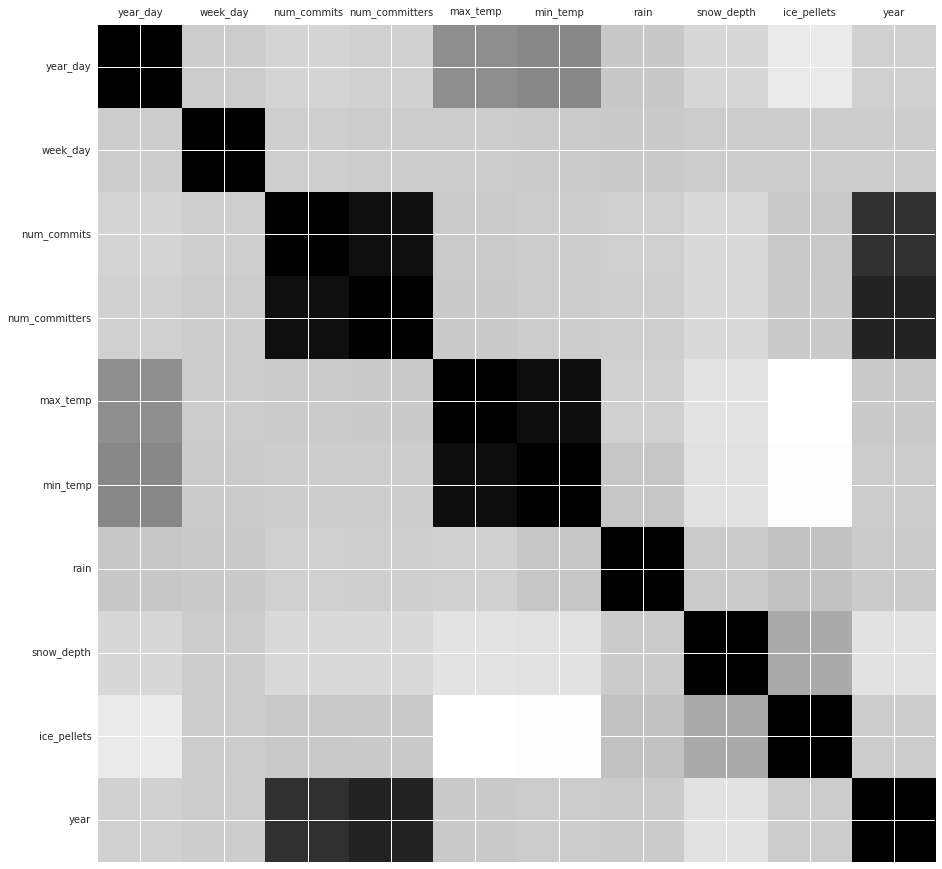

In [582]:
plot_corr(input_data)

We see that indeed there is a strong correlation between year and num_commits.

Unfortunately, most of the weather parameters don't seem to have to strong an effect on the number of commits, excluding the snow depth, which has a negative effect on this number.

max and min temp are also strongly correlated, so that it might be enough to just use one of them, or the average, instead of both. They are also correlated to the time of the year (year_day), which is not very surprising.


In [583]:
input_data.groupby('year').num_commits.mean()

year
2000      5.086806
2001      7.718475
2002      7.107784
2003      9.778090
2004      7.302752
2005      5.714286
2006      4.223404
2007      8.516320
2008     15.288571
2009     25.648352
2010     55.742466
2011     70.879452
2012     96.456284
2013    120.224658
2014    139.931507
2015    170.276712
2016    148.691257
2017    102.931298
Name: num_commits, dtype: float64

We see a very big difference between recent years compared to the number of commits in the early 2000's. 

It's likely that commit patterns have changed quite a bit, so using older data might negatively affect our predictor. We'll limit our investigation to data from after 2010. It will remove a lot of data, but data that is too different would hurt more than it would help.

In [631]:
input_data = input_data[input_data.year >= 2010]

input_data.shape

(2688, 11)

We don't want our model to be affected by the year, so we'll normalize our data to remove this correlation:

In [587]:
input_data['normalized_commits'] = input_data.groupby('year').num_commits.transform(lambda x: x/x.mean())

There is an implied assumption here about commit patterns being similar enough at least for these few years, with the only difference being the scale of the number of commits. As the order of magnitude of the number of commits for these years is similar, this seems like a safe assumption.

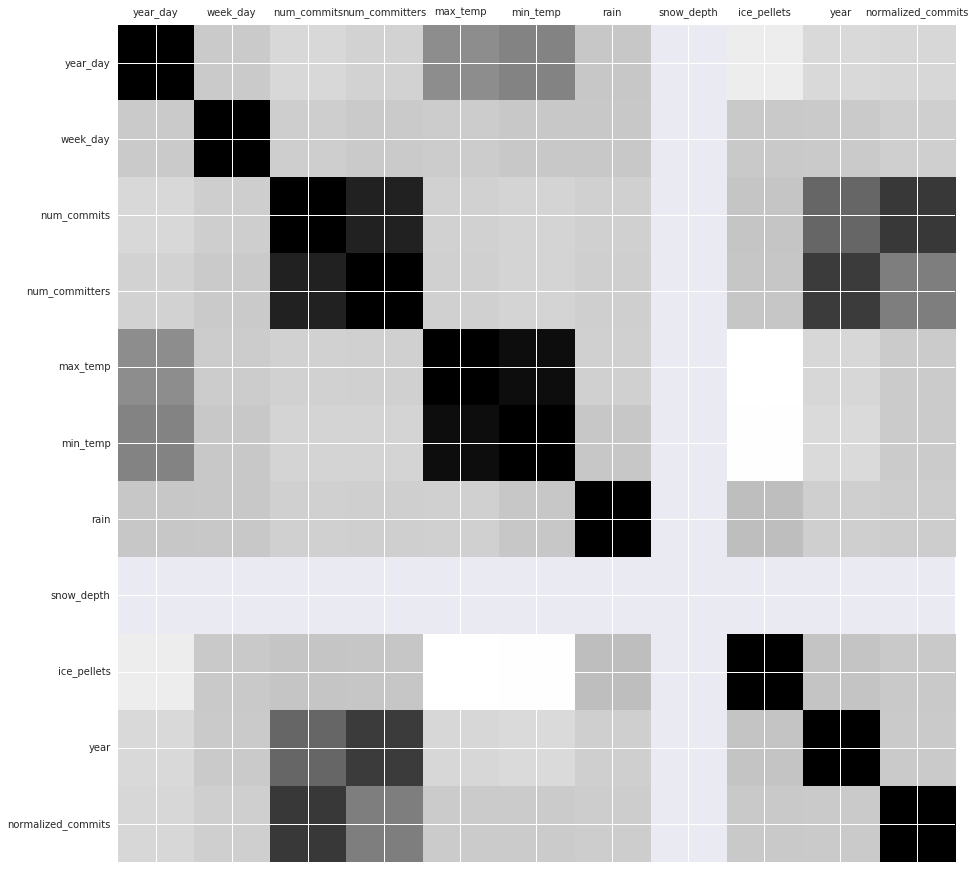

In [588]:
plot_corr(input_data)

The correlation between the year and the normalized amount of commits was successfully removed.

We also see that the correlation between snow depth and number of commits disappeared. This is because we are only looking at data from after 2010, and all the entries that had none-zero snow depth were earlier than that:

In [589]:
input_data.snow_depth.value_counts()

0.0    2688
Name: snow_depth, dtype: int64

It's unfortunate to lose this connection, and it might be interesting to look at years with non-zero snow depth values, but since there were relatively few commits back then compared to recent years, I feel they would not offer a reliable prediction on what will happen in the future. 

For now, we'll remove the snow depth and try to build a model without it.

In [594]:
input_data = input_data[[x for x in input_data.columns if x!='snow_depth']]

We are now ready to start working on our prediction model(s)

## Neural network

With the low amount of samples and features in our data, a neural network is probably not the ideal model.

It's unlikely that the available data is enough to properly train a deep neural network with its large number of free parameters, so we'll start with a single hidden layer, and see what we get.

We prepare the training data:

In [714]:
input_data = input_data.sample(frac=1) #shuffling data because Keras' validation_split takes rows from the end
X_train = input_data[input_data.year < 2016][['year_day', 'week_day', 'max_temp', 'min_temp', 'rain', 'ice_pellets']].values
Y_train = input_data[input_data.year < 2016]['normalized_commits'].values

#We can add some additional scaling and normalization to our input parameters (except ice_pellets, which we'd like to stay binary), to improve the model's performance
scaler = preprocessing.StandardScaler()
X_temp = scaler.fit_transform(X_train[:, :-1])
X_train = np.concatenate((X_temp, X_train[:, -1:]), axis=1)

2016 is the latest full year of data we have, so we'll leave it out and use it for testing.

**We should note that ideally, we should not incorporate the weekday and day of year into our model. These could have a much stronger correlation than any weather effects, and thus might obfuscate them.**

**A more reliable representation of the relation between commits and the weather could be achieved by only looking at data for the same weekday, or just one day of year. However, that would leave us with a tiny dataset, from which it would be hard to predict anything.**

## Model 1

We can use a fairly straightforward model, one hidden layer with rectified linear activation, some dropout to avoid overfitting and a linear output node to get our predicted value for the number of commits. 20 nodes is a somewhat arbitrary number, and a bit large considering we are only inputting 6 features into the model, but with the regularisation on this layer, it shouldn't be too much of a problem.

In [715]:
model = Sequential()
model.add(Dense(20, activation = 'relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',
      loss='mean_squared_error')

In [716]:
hist = model.fit(X_train, Y_train, batch_size=30, epochs=400, verbose=0, validation_split=0.2)

Before we take a look at the results of our model, we need some benchmark we can compare them to.

A simple and straightforward method would be to compare them to the average number of commits per day. If we are able to beat a prediction strategy that just guesses the average every time, it would mean that our model has at least learned **_something_**

In [717]:
np.mean((Y_train - np.mean(Y_train))**2)

0.2046428910692808

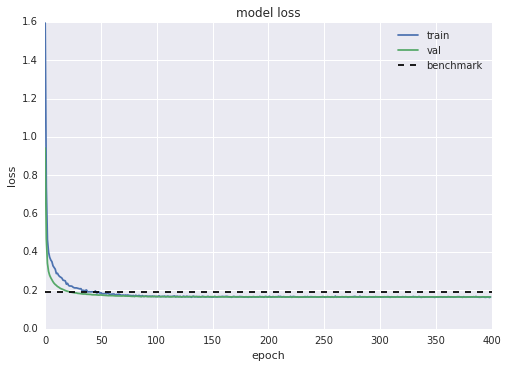

In [718]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.axhline(y=0.19370851846572007, color='k', linestyle='--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'benchmark'])
plt.show()

The loss for the train and the validation follow almost identical curves, so it seems we have avoided overfitting on the input data.

Let's see what the actual loss is at the end of the training process:

In [769]:
hist.history['loss'][-1:]

[0.16720724937646356]

We were able to beat the average, but not by a huge margin. 

We can test ourselves using the more recent data:

In [728]:
X_test = input_data[input_data.year == 2016][['year_day', 'week_day', 'max_temp', 'min_temp', 'rain', 'ice_pellets']].values
Y_test = input_data[input_data.year == 2016]['normalized_commits'].values

#We can add some additional scaling and normalization to our input parameters (except ice_pellets, which we'd like to stay binary), to improve the model's performance
scaler = preprocessing.StandardScaler()
X_temp = scaler.fit_transform(X_test[:, :-1])
X_test = np.concatenate((X_temp, X_test[:, -1:]), axis=1)

model.evaluate(X_test, Y_test, batch_size=32, verbose=2)

0.11306263253988465

In [730]:
X_test = input_data[input_data.year >= 2016][['year_day', 'week_day', 'max_temp', 'min_temp', 'rain', 'ice_pellets']].values
Y_test = input_data[input_data.year >= 2016]['normalized_commits'].values

#We can add some additional scaling and normalization to our input parameters (except ice_pellets, which we'd like to stay binary), to improve the model's performance
scaler = preprocessing.StandardScaler()
X_temp = scaler.fit_transform(X_test[:, :-1])
X_test = np.concatenate((X_temp, X_test[:, -1:]), axis=1)

model.evaluate(X_test, Y_test, batch_size=32, verbose=2)

0.1087371562748128

Our loss when evaluating 2016 data is much lower than the train loss and it's even lower if we also include 2017.

This could be a fluke, due to the lower amount of data.

It could also be justified. A couple of positive reasons for this might be:

1. The model picked up on a trend that is growing over the years, getting higher the more we advance in time
2. The more recent data is more reliable, and thus has less noise

## Model 2

It's not very likely it would help, but since we're already "playing" with neural networks, we might as well see how it affects the model if we add another hidden layer. We'll make this one smaller, 

In [760]:
input_data = input_data.sample(frac=1) #shuffling data because Keras' validation_split takes rows from the end
X_train = input_data[input_data.year < 2016][['year_day', 'week_day', 'max_temp', 'min_temp', 'rain', 'ice_pellets']].values
Y_train = input_data[input_data.year < 2016]['normalized_commits'].values

#We can add some additional scaling and normalization to our input parameters (except ice_pellets, which we'd like to stay binary), to improve the model's performance
scaler = preprocessing.StandardScaler()
X_temp = scaler.fit_transform(X_train[:, :-1])
X_train = np.concatenate((X_temp, X_train[:, -1:]), axis=1)

In [761]:
model = Sequential()
model.add(Dense(20, activation = 'relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer='adadelta',
      loss='mean_squared_error')

In [762]:
hist = model.fit(X_train, Y_train, batch_size=30, epochs=400, verbose=0, validation_split=0.2)

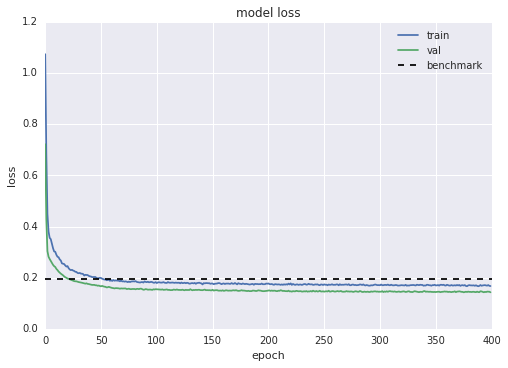

In [766]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.axhline(y=0.19370851846572007, color='k', linestyle='--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'benchmark'])
plt.show()

In [770]:
hist.history['loss'][-1:]

[0.16720724937646356]

In [765]:
X_test = input_data[input_data.year >= 2016][['year_day', 'week_day', 'max_temp', 'min_temp', 'rain', 'ice_pellets']].values
Y_test = input_data[input_data.year >= 2016]['normalized_commits'].values

#We can add some additional scaling and normalization to our input parameters (except ice_pellets, which we'd like to stay binary), to improve the model's performance
scaler = preprocessing.StandardScaler()
X_temp = scaler.fit_transform(X_test[:, :-1])
X_test = np.concatenate((X_temp, X_test[:, -1:]), axis=1)

model.evaluate(X_test, Y_test, batch_size=32, verbose=2)

0.10818242927792086

The results are almost identical to those of the first model.

It would appear that adding another layer did not improve our model.

## Model 3

While the regression models above were able to achieve some level of prediction, we might be able to get a better solution if we were to simplify the problem.

We could just try to predict whether on a given day there would be a high or low number of commits, without predicting the exact number

To decide how we should divide our categories, let's look at the distribution of normalized_commits:

In [871]:
input_data.normalized_commits.describe()

count    2688.000000
mean        1.000000
std         0.440205
min         0.035879
25%         0.690374
50%         0.957611
75%         1.247664
max         3.641748
Name: normalized_commits, dtype: float64

In [886]:
input_data['categories'] = pd.cut(input_data['normalized_commits'], bins=[0,0.95,3.7], labels=[0,1])

In [877]:
input_data.head()

,date,year_day,week_day,num_commits,num_committers,max_temp,min_temp,rain,ice_pellets,year,normalized_commits,categories,ordered_weekday
827,2016-09-14,258,4,141,47,90.0,60.1,0.00,0,2016,0.948274,0,3
1260,2017-01-06,6,6,110,35,30.9,24.8,0.01,1,2017,1.068674,1,5
614,2013-11-22,326,6,156,38,48.0,28.9,0.01,0,2013,1.297571,1,5
1136,2012-12-11,346,3,118,31,60.1,41.0,0.15,0,2012,1.223352,1,2
1855,2010-04-26,116,2,76,17,62.1,46.9,0.00,0,2010,1.363413,1,1


In [878]:
input_data = input_data.sample(frac=1) #shuffling data because Keras' validation_split takes rows from the end
X_train = input_data[input_data.year < 2016][['year_day', 'week_day', 'max_temp', 'min_temp', 'rain', 'ice_pellets']].values
Y_train = input_data[input_data.year < 2016]['categories'].values
Y_train = np_utils.to_categorical(Y_train, 3) #need to give Y the right form for softmax

scaler = preprocessing.StandardScaler()
X_temp = scaler.fit_transform(X_train[:, :-1])
X_train = np.concatenate((X_temp, X_train[:, -1:]), axis=1)

In [879]:
model_2 = Sequential()
model_2.add(Dense(20, activation = 'relu', input_dim=X_train.shape[1]))
model_2.add(Dropout(0.2))
model_2.add(Dense(10, activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(Y_train.shape[1], activation='softmax'))

model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [880]:
hist = model_2.fit(X_train, Y_train, batch_size=30, epochs=400, verbose=0, validation_split=0.2)

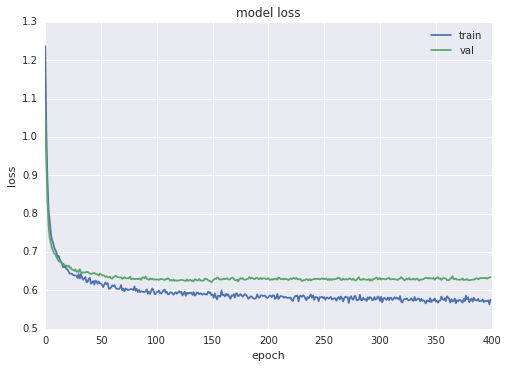

In [881]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

Our model seems to be overfitting a bit. We'll see how well it does on the test data.

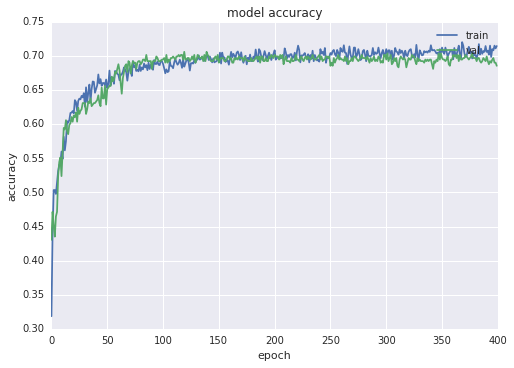

In [882]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [883]:
hist.history['acc'][-1:]

[0.71461187405129001]

In [884]:
input_data = input_data.sample(frac=1) #shuffling data because Keras' validation_split takes rows from the end
X_test = input_data[input_data.year >= 2016][['year_day', 'week_day', 'max_temp', 'min_temp', 'rain', 'ice_pellets']].values
Y_test = input_data[input_data.year >= 2016]['categories'].values
Y_test = np_utils.to_categorical(Y_test, 3) #need to give Y the right form for softmax

scaler = preprocessing.StandardScaler()
X_temp = scaler.fit_transform(X_test[:, :-1])
X_test = np.concatenate((X_temp, X_test[:, -1:]), axis=1)

In [885]:
model_2.evaluate(X_test, Y_test, verbose=1)

 32/497 [>.............................] - ETA: 0s

[0.63054852214617507, 0.69014084555013799]

Not too bad. Even with the slight overfitting, the model was able to predict the 2016-2017 days with high or low commits at almost a 70% accuracy

## What is the best kind of model for this problem?

There are a number of reasons to believe that a neural network is not the optimal model for this problem.

First of all, **our number of samples is limited by the number of days**. Since Github has only been around for about 20 years, we only have thousands of days to work with. We could multiply this by looking at various locations, not just MIT, but as we mentioned previously, places might react very differently to similar weather conditions, further complicating the problem.

Second, **the number of available features is not very large**. Most of the fields in the weather data seem to have little or no effect on Github commits. We found only 6 to be relevant in this analysis.

Neural networks with hidden layers have a lot of degrees of freedom that need to be determined. The 2 reasons mentioned above mean that we have very limited data to do so reliably.
Of course, we could train a neural network with no hidden layers, but that has no advantage over "classical" machine learning algorithms.

Which leads us to the third reason:

**The features here don't seem to have complex non-linear relations between them**. We don't need a model with deep layers to find some strange way to mix the precipitation and the temperature to predict our result. If a relation does exist, it can probably be found by dividing each dimension of the problem either linearly or through a relatively simple kernel. Hence some model like SVM, RandomForest or even logistic regression might be able to do the trick.

Let's put this last assertion to the test:

## "Classical" model

We can train a random forest classifier and compare its results to our third model

Before we start, we'll help our trees a bit by ordering the weekdays so that the weekend days are together:

In [890]:
def reorder_weekday(day):
  if day==1:
    return 7
  else:
    return day-1

In [891]:
input_data['ordered_weekday'] = input_data.week_day.apply(reorder_weekday)

In [887]:
X_train_2 = input_data[input_data.year < 2016][['year_day', 'ordered_weekday', 'max_temp', 'min_temp', 'rain', 'ice_pellets']].values #no real need to scale this for a random forest

Y_cat = input_data[input_data.year < 2016]['categories'] 

clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)

param_grid = {"max_depth": [3, 4, None],
              "max_features": [1, 3, 6],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10]}


grid_search = GridSearchCV(clf, param_grid=param_grid)
grid_search.fit(X_train_2, Y_cat)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 3, 6], 'min_samples_split': [1, 3, 10], 'max_depth': [3, 4, None], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [889]:
grid_search.best_score_  

0.70789593792788685

The result we found is surprisingly similar to that of our third model.

We can also see how well this model does on our test data: 

In [892]:
X_test_2 = input_data[input_data.year >= 2016][['year_day', 'ordered_weekday', 'max_temp', 'min_temp', 'rain', 'ice_pellets']].values #no real need to scale this for a random forest

Y_cat_test = input_data[input_data.year >= 2016]['categories'] 

grid_search.score(X_test_2, Y_cat_test)

0.73038229376257546

Relatively easily, this model achieved better results than our neural network above

## Some conclusions

* There doesn't appear to be a very strong correlation between the weather and Github commits, which is not overly surprising


* Given this fact, the performance of our NN models was not too bad


* Our Random Forest approach, even without much work or optimization (just an out-of-the-box gridsearch) was able to give us results that are comparable to those of the NN


* However, it is important to note that we did "help" the RF a bit by doing some additional preprocessing on the weekdays - a feature that has a large effect on the number of commits. This is the type of thing that an effective deep NN would have been able to do on its own (and might have done it in one of our NN models)